In [1]:
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.9f' % x)
pd.set_option('display.max_columns', None)

import numpy as np

from google.colab import drive
import os

import seaborn as sns 
sns.set()

import matplotlib
import matplotlib.pyplot as plt

In [2]:
drive.mount("/content/drive")
contentFolder = "/content/drive/MyDrive/Austral - Data Mining"
if not os.path.exists(contentFolder):
    os.mkdir(contentFolder)

Mounted at /content/drive


## Ejercicio 1

In [3]:
orders = pd.read_csv("{}/orders.txt".format(contentFolder), sep=";")
ordersDetails = pd.read_csv("{}/ordersDetails.txt".format(contentFolder), sep=";")

## Ejercicio 2

### Ejercicio 2.a

In [4]:
print("cantidad de ordenes: {}".format(len(orders)))

cantidad de ordenes: 504121


In [5]:
#abiertas por taget (valores absolutos)
orders.groupby("target").size()

target
0    269544
1    234577
dtype: int64

In [6]:
#abiertas por taget (valores relativos)
orders.groupby("target").size() / len(orders)

target
0   0.534681158
1   0.465318842
dtype: float64

### Ejercicio 2.b

In [7]:
aggregate = ordersDetails.groupby("orderID").agg({"quantity": "sum"})

print("en promedio se compran {} productos".format(aggregate.quantity.mean()))

en promedio se compran 2.8273351040722368 productos


El promedio de unidades compradas por orden es de 2.82 productos

### Ejercicio 2.c

In [8]:
print("la mediana de los productos comprados es de {}".format(ordersDetails.price.median()))

la mediana de los productos comprados es de 29.99


La mediana de la variable _**price**_ es de 29.99

In [9]:
ordersDetails.price.isnull().sum()

0

In [10]:
print("existen {} registros donde la variable price tiene un valor menor o igual a 0".format(len(ordersDetails[ordersDetails.price <= 0])))

existen 29826 registros donde la variable price tiene un valor menor o igual a 0


Podemos decir que la variable _**price**_ posee valores faltantes ya que hay valores para la variable menores o iguales a 0.

### Ejercicio 2.d

In [11]:
orders.isnull().sum()

orderID          0
orderDate        0
customerID       0
deviceID         0
paymentMethod    0
target           0
dtype: int64

In [12]:
ordersDetails.isnull().sum().sort_values(ascending = False)

productGroup     341
rrp              341
voucherID          6
orderID            0
articleID          0
colorCode          0
sizeCode           0
quantity           0
price              0
voucherAmount      0
dtype: int64

In [13]:
len(ordersDetails[ordersDetails.rrp <= 0])

9676

In [14]:
len(ordersDetails[ordersDetails.voucherID == '0'])

1157176

In [15]:
len(ordersDetails[ordersDetails.quantity <=0])

20152

Podemos encontrar valores nulos en las variables productGroup (341), rrp (341) y voucherID (6). No obstante si consideramos que el precio de referencia no puede ser un valor menor o igual a 0, detectamos que dicha variable aumenta en 9.676 y si filtramos la variable voucherID == '0', encontramos 1.157.176 sin valores.

* productGroup -> 341
* rrp -> 10.017
* voucherID -> 1.157.182
* price -> 29826
* quantity -> 20152

## Ejercicio 3

### Trabajamos sobre la variable *_price_*

In [16]:
#Si la variable price posee valor 0, utilizo el valor de rrp
ordersDetails["price"] = np.where(ordersDetails.price <= 0, ordersDetails.rrp, ordersDetails.price)

In [17]:
#para aquellos valores en donde rrp no tampoco tiene, usamos la mediana
median = ordersDetails[ordersDetails.price > 0].price.median()
ordersDetails["price"] = np.where(ordersDetails.price <=0, median, ordersDetails.price)

In [18]:
#Validamos que no hay más valores en 0 en la variable price
(ordersDetails.price<=0).sum()

0

### Trabajamos sobre la variable *quantity*

In [19]:
(ordersDetails.quantity <= 0).sum()

20152

La moda en la variable _quantity_ nos indica que la mayor cantidad de items son por 1 unidad. Por tal motivo podemos utilizar esta estrategia para que si la variable quantity tiene un valor _"missing"_ sea reemplazado por 1

In [20]:
mode = ordersDetails.quantity.mode()
ordersDetails["quantity"] = np.where(ordersDetails.quantity <= 0, mode, ordersDetails.quantity)

In [21]:
(ordersDetails.quantity <= 0).sum()

0

### Trabajamos sobre la variable _rrp_

In [22]:
ordersDetails["rrp"] = np.where((ordersDetails.rrp.isnull()) | (ordersDetails.rrp <= 0), ordersDetails.price, ordersDetails.rrp)

In [23]:
ordersDetails.rrp.isnull().sum()

0

In [24]:
(ordersDetails.rrp <=0).sum()

0

### Trabajamos sobre la variable _voucherID_

In [25]:
#La variable voucherID nos indica si la order tiene una promoción hecha por un voucher o no. 
#Vamos a crear un flag indicando si la línea de la orden tiene o no el voucher, para luego agregarla a la orden

ordersDetails["flagVoucher"] = np.where((ordersDetails.voucherID.isnull()) | (ordersDetails.voucherID == "0"), 0,1)


In [26]:
ordersDetails.groupby("flagVoucher").size()/len(ordersDetails)

flagVoucher
0   0.808883881
1   0.191116119
dtype: float64

In [27]:
#eliminamos la variable VoucherID
ordersDetails.drop(columns=["voucherID"], inplace=True)

### Trabajamos sobre la variable _productGroup_

In [28]:
mode = ordersDetails.productGroup.mode()
ordersDetails["productGroup"] = np.where(ordersDetails.productGroup.isnull(), mode, ordersDetails.productGroup)

In [29]:
ordersDetails.productGroup.isnull().sum()

0

## Ejercicio 4

In [30]:
#hacer un count distinct de articleID por orderID
aux = ordersDetails[["orderID", "articleID"]].drop_duplicates().groupby("orderID").articleID.count().to_frame("distinctProducts").reset_index()
orders = pd.merge(orders, aux, how="left", on="orderID")

In [31]:
#Eliminamos el dataset aux
del aux

## Ejercicio 5

In [32]:
aux = ordersDetails.groupby(["orderID", "articleID"]).agg({
    "sizeCode":"nunique"
}).reset_index()
aux = aux.groupby("orderID").agg({
    "sizeCode": "max"
}).reset_index().rename({"sizeCode":"flagMismoProductoDiferenteTamanio"}, axis = 1)
orders = pd.merge(orders, aux, how="left", on="orderID")
orders["flagMismoProductoDiferenteTamanio"] = np.where(orders.flagMismoProductoDiferenteTamanio == 1,0,1)

In [33]:
del aux

In [34]:
orders.groupby("flagMismoProductoDiferenteTamanio").size()

flagMismoProductoDiferenteTamanio
0    437289
1     66832
dtype: int64

## Ejercicio 6

In [35]:
aux = ordersDetails.groupby(["orderID", "articleID"]).agg({
    "colorCode":"nunique"
}).reset_index()
aux = aux.groupby("orderID").agg({
    "colorCode": "max"
}).reset_index().rename({"colorCode":"flagMismoProductoDiferenteColor"}, axis = 1)
orders = pd.merge(orders, aux, how="left", on="orderID")
orders["flagMismoProductoDiferenteColor"] = np.where(orders.flagMismoProductoDiferenteColor == 1,0,1)

In [36]:
del aux

## Ejercicio 7

In [37]:
aux = ordersDetails.groupby("orderID").agg({
    "flagVoucher": "max"
}).reset_index()
orders = pd.merge(orders, aux, how="left", on="orderID")

In [38]:
del aux

## Ejercicio 8

In [39]:
aux = ordersDetails.groupby("orderID").agg({
    "price":"sum"
}).reset_index().rename({"price":"totalPrice"}, axis = 1)
orders = pd.merge(orders, aux, how="left", on="orderID")

In [40]:
del aux

## Ejercicio 9

In [41]:
ordersDetails["flagPrecioMenorRrp"] = np.where(ordersDetails.price < ordersDetails.rrp,1,0)
aux = ordersDetails.groupby("orderID").agg({
    "flagPrecioMenorRrp":"max"
})
orders = pd.merge(orders,aux, how="left", on="orderID")

## Ejercicio 10

In [42]:
orders["totalPriceDeciles"] = pd.qcut(orders.totalPrice, 10, labels=False)


In [43]:
orders.groupby("totalPriceDeciles").size()

totalPriceDeciles
0    55265
1    50288
2    50057
3    47442
4    50878
5    49108
6    49863
7    50475
8    50336
9    50409
dtype: int64

## Ejercicio 11

In [44]:
orders["orderDate"] = pd.to_datetime(orders["orderDate"], format = "%Y-%m-%d")

In [45]:
orders["diaSemana"] = orders.orderDate.dt.dayofweek
orders["trimestre"] = orders.orderDate.dt.quarter
orders["mesCompra"] = orders.orderDate.dt.month
orders["diaCompra"] = orders.orderDate.dt.day

## Ejercicio 12

## Ejercicio 18

In [50]:
orders["customerID"] = orders.customerID.str[1:]

## Ejercicio 19

In [51]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(orders.paymentMethod)
orders["paymentMethod"] = le.transform(orders.paymentMethod)

In [59]:
orders.to_csv("{}/finalOrders.txt".format(contentFolder), sep=";", index=False)

## Ejercicio 13

Text(0.5, 1.0, '# Testeos confirmados abiertos por Género')

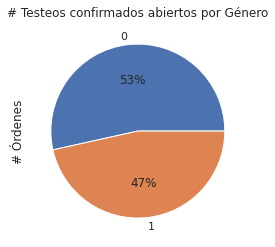

In [47]:
ax = orders.groupby("target").size().plot(kind="pie", autopct="%2.f%%")
ax.set_ylabel("# Órdenes")
plt.title('# Testeos confirmados abiertos por Género')

## Ejercicio 14

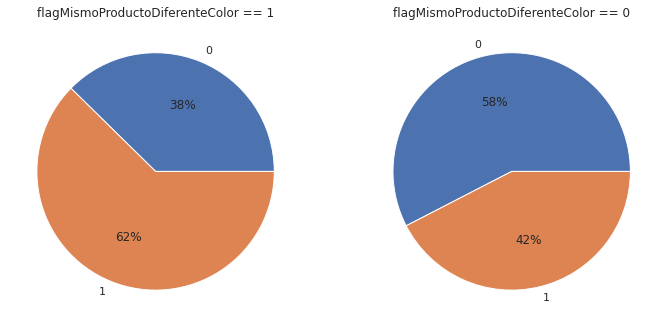

In [48]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
figure, axis = plt.subplots(1, 2)


axis[0].pie(
    orders[orders.flagMismoProductoDiferenteColor == 1]\
    .groupby("target").size(),
    labels = orders[orders.flagMismoProductoDiferenteColor == 1]\
    .groupby("target").size().index,
    autopct="%2.f%%"
)
axis[0].title.set_text ("flagMismoProductoDiferenteColor == 1")


axis[1].pie(
    orders[orders.flagMismoProductoDiferenteColor == 0]\
    .groupby("target").size(),
    labels = orders[orders.flagMismoProductoDiferenteColor == 0]\
    .groupby("target").size().index,
    autopct="%2.f%%"
)
axis[1].title.set_text ("flagMismoProductoDiferenteColor == 0")

## Ejercicio 15

Text(0.5, 1.0, 'Órdenes abiertas por target y totalPriceDeciles')

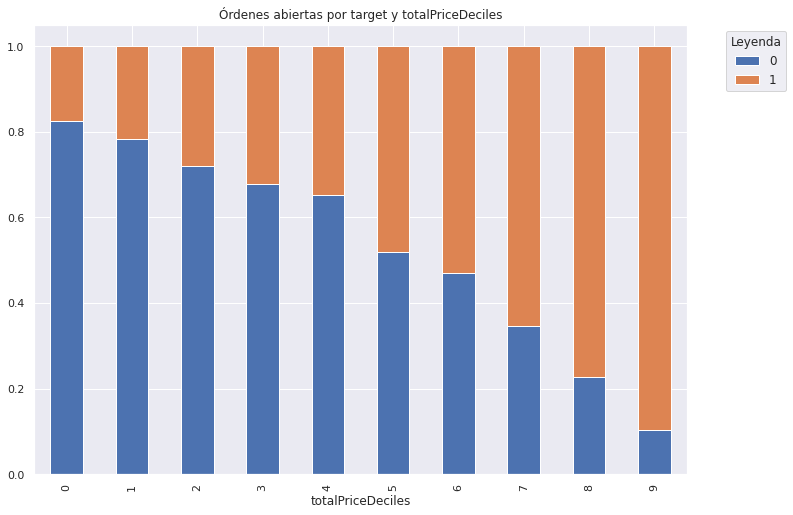

In [49]:
from matplotlib.font_manager import FontProperties
fontP = FontProperties()
fontP.set_size('medium')

baseGraficos = orders.groupby(["totalPriceDeciles", "target"]).size().to_frame("q_ordenes")
baseGraficos = baseGraficos.join(baseGraficos.groupby("totalPriceDeciles").q_ordenes.sum().to_frame("q_totales"))
baseGraficos["% ordenes"] = baseGraficos.q_ordenes / baseGraficos.q_totales
ax = baseGraficos["% ordenes"].unstack().plot(kind='bar', stacked=True, legend=None)
plt.legend( title='Leyenda', bbox_to_anchor=(1.05, 1), loc='upper left', prop=fontP)
plt.title("Órdenes abiertas por target y totalPriceDeciles")